In [1]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from glob import glob
import re
import os.path
import scipy.misc
import numpy as np
import random
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import keras.backend as K
namefile = 'unet_160x576'
image_shape = (160, 576)  
data_dir = './CarND-Semantic-Segmentation-master/data_erik'
batch_size = 5

Using TensorFlow backend.


In [2]:
def generator(data_folder, image_shape, batch_size):
    """  Create batches of training and validation data """
    image_paths = glob(os.path.join(data_folder, 'images', '*.png'))
    label_paths = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_folder, 'labels', '*_road_*.png'))}
    
    background_color = np.array([255, 0, 255])  ## Solo el magenta

    random.shuffle(image_paths)
    while 1: 
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)  #Binarizar la segmentación del target
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)   # Añadirle una dimensión al tensor
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)  #crear dos capas reflejo
                
                images.append(image)
                gt_images.append(gt_image)
                
            X = np.array(images)
            Y = np.array(gt_images)
            yield (X, Y)
        
train_generator = generator(os.path.join(data_dir, 'training'), image_shape, batch_size)
validation_generator = generator(os.path.join(data_dir, 'validation'), image_shape, batch_size)      


In [3]:
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(K.clip(y_true_f + y_pred_f, 0, 1))
    return intersection/union


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [4]:
def unet(img_rows, img_cols, img_channels):  # 23 trainable layers, use same padding, en lugar de unpadding layers
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv7)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
    
    conv9 = Conv2D(1024, (3, 3), padding='same', activation='relu')(pool4)
    conv10 = Conv2D(1024, (3, 3), padding='same', activation='relu')(conv9)
    
    # Decoder
    convT1 = Conv2D(512, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv10))
    merge1 = concatenate([convT1, conv8], axis=3)
    conv11 = Conv2D(512, (3, 3), padding='same', activation='relu')(merge1)
    conv12 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv11)
    
    convT2 = Conv2D(256, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv12))
    merge2 = concatenate([convT2, conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), padding='same', activation='relu')(merge2)
    conv14 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv13)
    
    convT3 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv14))
    merge3 = concatenate([convT3, conv4], axis=3)
    conv15 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge3)
    conv16 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv15)
    
    convT4 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv16))
    merge4 = concatenate([convT4, conv2], axis=3)
    conv17 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge4)
    conv18 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv17)

    y = Conv2D(2, (1, 1), activation='softmax')(conv18)

    return Model(inputs=x, outputs=y) 

In [19]:
def unet01(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    
    # Decoder   
    convT = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv4))
    merge = concatenate([convT, conv2], axis=3)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge)
    conv6 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv5)
    
    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv6)

    return Model(inputs=x, outputs=y)

In [7]:
def unet02(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv5)
    
    # Decoder   
    convT1 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv6))
    merge1 = concatenate([convT1, conv4], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge1)
    conv8 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv7)
    
    convT2 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv8))
    merge2 = concatenate([convT2, conv2], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge2)
    conv10 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv9)  

    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv10)

    return Model(inputs=x, outputs=y)

In [6]:
model = unet(image_shape[0],image_shape[1],3)
adam = optimizers.Adam(lr=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[IOU_calc])
#checkpointer = ModelCheckpoint(filepath='bestmodel_' + namefile + '.h5', monitor='val_loss', verbose=0, save_best_only=True,
#                              mode='min', period=1)
#h = model.fit_generator(train_generator, steps_per_epoch=200//batch_size, epochs=50, verbose=1, callbacks=[checkpointer], 
#                        validation_data=validation_generator, validation_steps=89//batch_size)


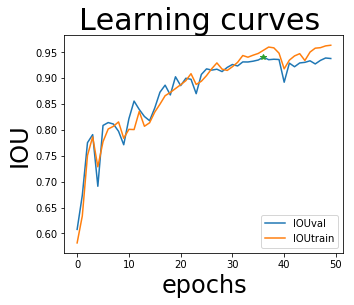

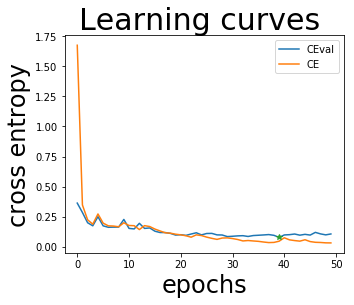

In [7]:
plt.rcParams['figure.figsize'] = (5,4) # Hacer las figuras más grandes
epoch_max = np.argmax(h.history['val_IOU_calc'])
plt.plot(h.history['val_IOU_calc'], label='IOUval')
plt.plot(h.history['IOU_calc'], label='IOUtrain')
plt.legend(loc='lower right')
plt.plot(epoch_max, h.history['val_IOU_calc'][epoch_max],'*')
plt.xlabel('epochs', fontsize=24)
plt.ylabel('IOU', fontsize=24)
plt.suptitle('Learning curves', fontsize=30)
plt.savefig('IOU_bestmodel_' + namefile + '.pdf', bbox_inches='tight')
plt.show()


epoch_max = np.argmin(h.history['val_loss'])
plt.plot(h.history['val_loss'], label='CEval')
plt.plot(h.history['loss'], label='CE')
plt.legend(loc='upper right')
plt.plot(epoch_max, h.history['val_loss'][epoch_max],'*')
plt.xlabel('epochs', fontsize=24)
plt.ylabel('cross entropy', fontsize=24)
plt.suptitle('Learning curves', fontsize=30)
plt.savefig('CE_bestmodel_' + namefile + '.pdf', bbox_inches='tight')
plt.show()





In [7]:
# Evaluar el mejor modelo
model.load_weights('bestmodel_' + namefile + '.h5')

score_train = model.evaluate_generator(train_generator, steps=89//batch_size)
print('training', score_train)
score_val = model.evaluate_generator(validation_generator, steps=89//batch_size)
print('validation', score_val)

training [0.038394258960204965, 0.95403657240026141]
validation [0.079250215169261479, 0.93399322383544026]


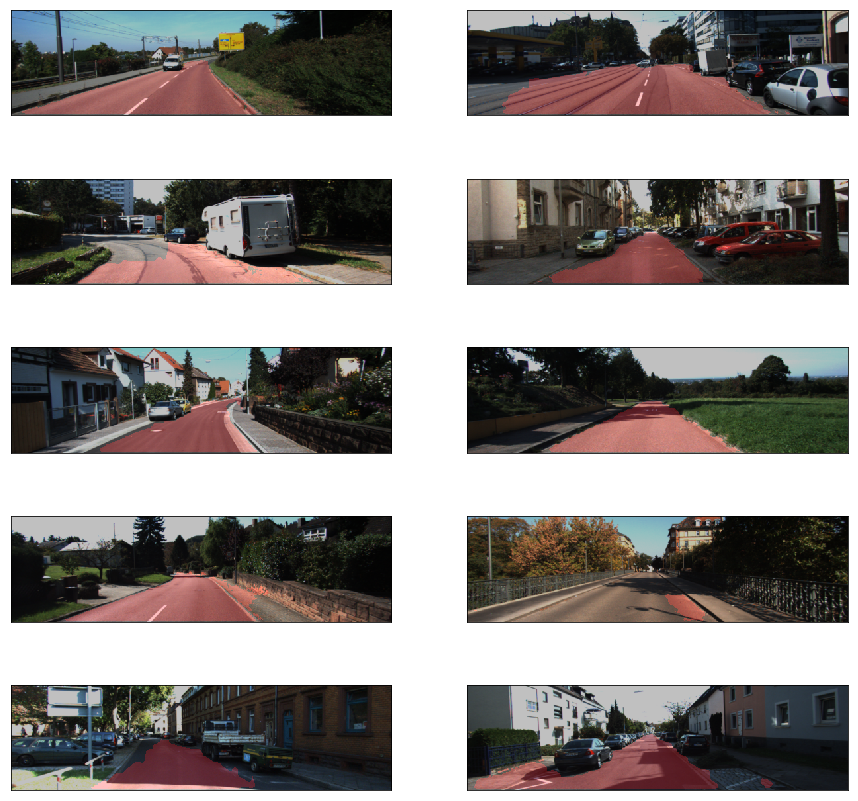

In [10]:
plt.rcParams['figure.figsize'] = (15,15) # Hacer las figuras más grandes
data_folder = './CarND-Semantic-Segmentation-master/data/data_road/testing/image_2/'
th_segment = 0.5
k = 10
filelist = glob(os.path.join(data_folder, '*.png'))
random.shuffle(filelist)
i = 1
for image_file in filelist[0:k]:
    img_original = scipy.misc.imread(image_file)
    img = scipy.misc.imresize(img_original, image_shape)
    y = model.predict(np.expand_dims(img, axis=0), batch_size=1)
    mask = np.stack([y[0,:,:,0] > th_segment,np.zeros(image_shape),np.zeros(image_shape)], axis=2)
    masked = np.ma.masked_array(mask, img).astype('float32')
    plt.subplot(5,2,i)
    plt.imshow(img,interpolation='none') 
    plt.imshow(masked, interpolation='none', alpha=0.25) 
    plt.tick_params(axis='both',which='both',bottom='off',left='off',labelbottom='off',labelleft='off') 
    i += 1
#plt.savefig('photos_bestmodel_' + namefile +'.pdf', bbox_inches='tight')
plt.show()